# Parametrisation of uncertainty values in the MISO2 model

### Input variables
Input variables of the MISO2 model other than allocation parameters have the dimensions c (country), e (element; unity), m (material), y (year). The element dimension is present as an index, but since there is only the unity element in the MISO2 definition, it is omitted from formulas. Each input variable $X$ follows an uncertainty distribution:

$$X_{c, m, y} ∼D_{c, m, y}, \quad D \in \{\mathcal{F}, \mathcal{N}, \mathcal{LN}, \mathcal{U}, \mathcal{U}_{l} \}$$

Where $\mathcal{F}$ is a fixed value, usually identical to the original input, $\mathcal{N}$ is the normal distribution, $\mathcal{LN}$ the LogNormal distribution, $\mathcal{U}$ the Uniform distribution and $\mathcal{U}_{l}$ a left-shifted Uniform distribution used for recycling inputs.

Each input variable has an uncertainty assessment which translates into a coefficient of variation (CV) that parametrizes its distribution.

$$
\mathcal{N} (\mu= X, \quad \sigma= \mu \cdot CV) \\
\mathcal{LN} (\mu= X, \quad \sigma= CV) \\
\mathcal{U} \left[a,b\right], \quad a= X - X \cdot CV, b= X + X \cdot CV, \quad a \geq 0, \quad b\leq 1 \\
\mathcal{U}_{l} \left[a,b\right], \quad a= X - X \cdot CV \cdot 1.5, \quad b= X + X \cdot CV \cdot 0.5, \quad a \geq 0, \quad b\leq 1 \\
$$

Although distributions can be specified by variable, in the MISO2 input data all variables of a parameter follow the same distribution, e.g. primary production inputs follow the LogNormal distribution for all countries, all materials and all years, and only individually differ by their uncertainty assessment.

### Allocation parameters

Uncertainty is handled slightly different for allocation parameters, where variables over one dimensions need to sum up to a total of exactly 1. This is the case for the enduse-sector splits that follow a Dirichlet distribution:

$$X_{c, m, y} ∼ \mathcal{D}_{c, m, y} (\alpha), \alpha = \left(\alpha_1, \alpha_2, ..., \alpha_n \right), \quad n= \text{#enduse-sectors}$$

The alpha parameters are estimated following Helbig et al. 2022, S-19:

$$Var[X]=\frac{\frac{1}{4}}{\alpha_0+1}, \quad E [X_i ]= \frac{\alpha_i}{\alpha_0}$$

# Uncertainty implementations

### Monte Carlo simulation
 
Monte-Carlo randomisation is handled by the MISO2Config and MISO2MonteCarlo classes. If a config object is parsed with uncertainty parsing enabled, an uncertainty parametrisation will be created for all parameters that have information on their uncertainty sheet in their cover sheet. Parameters without the information are processed normally. A MonteCarlo object injected into the config that handles the generation of samples.

Uncertainty generation must be switched on explicitly for all parts of the workflow, during config creation (for parsing in uncertainties) and in the config object by enabling a monte carlo method.

_Note on input data structure_: Since values and uncertainty are parsed concurrently with matching indexes, currently either no uncertainty can be parsed or there must be an uncertainty distribution present for each value at the same index. This is handled automatically by the uncertainty creation scripts, but care must be taken when manually editing or sorting the tables. 

When running the model, the explicit monte carlo methods for multiprocessing must be used. They support automatic calculations of means and variance via an online algorithm, and/or saving the results to parquets. 

_Note on file saving_: This saves three parquets (of different dimensions) per region and mc run. This is not ideal, as the number of files can quickly overwhelm the file system, and will be changed to batch saving in future implementations. 

Uncertainty can be toggled for each individual parameter. When uncertainty is activated, the config will not return the original input data to the MISO2Model object, but a randomized version. A batch size needs to be supplied. When randomisation is active, for each individual variable this number of samples will be generated and then combined into the same number of randomised parameter dictionaries. The parameter dicts are stored in a queue that is refilled by a new batch, once it runs out.

_Note on batch size_: Pre-creation of batches is very memory intensive and needs to be tailored to the memory availability / number of processes. This is necessary, since the high number of input variables result in an equally high number of sampling calls.

This MC implementation was not used in the final results. When varying each variable independently, the uncertainty effects cancel out due to the aggregation effects over time, i.e. an increase in one year is offset by a decrease in the next. Overall, this produces very low uncertainties for stock variables that do not reflect the true uncertainty within the model. 

### Systematic-error ('biased') monte-carlo simulation

In the standard implementation described above, each input variable is sampled independently. This is the default implementation. Alternatively, a systematic-error version of the MonteCarlo object can be injected into the config. In terms of implementation this works analogously, with the exception that only samples that jointly deviate to above or below the input variable are aggregated into a config. In a randomized parameter dict returned by this MonteCarlo object, all variables are either sampled from above or below their original input variables. This information is contained in the metadata object of the output. Since the overall goal is to increase or decrease stocks, some parameters (such as AggregateMultipliers) have to be adjusted in the opposite direction to have the desired effect. The results of this scheme are hard to intuitively understand and introduce some logic inconsistencies (e.g. import/export balance), so it was not further pursued.

### One-at-a-time sensitivity testing

As a third option, uncertainty can be tested by one-at-a-time increase of parameter groups. Individual datapoints are adjusted by their CV in both direction each, which gives us a lower and upper bound for their overall impact on the model results. This version is discussed in more detail in the published article.

# Uncertainty parametrisation in Python

As the terminology around distributions in the original MISO2 data, the stats-array package, and the Scipy library used in the software is not identical, this document is meant as a reference to the implementation used in our software.

Uncertainty in the input data is specified by these parameters:

**Value** - Original value, usually the mean of the distribution and Scipy's "loc" attribute.

**CV** = First parameter of the distribution, usually the coefficient of variation. This is transformed into an appropriate scale parameter of a Scipy distribution. Please note while this is generally called CV, it might relate to different parameters for certain distribution as referenced in this document.

**Shape** = Second parameter of the distribution. Only relevant for Weibull, Gamma and Beta distribution.

**Minimum/Maximum**: Are taken from the global uncertainty settings for the normal distribution and provide hard limits. Usually they will specify zero as a minimum to prevent negative input data. For the Uniform distribution, these refer to the sample bounds.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

## Normal distribution

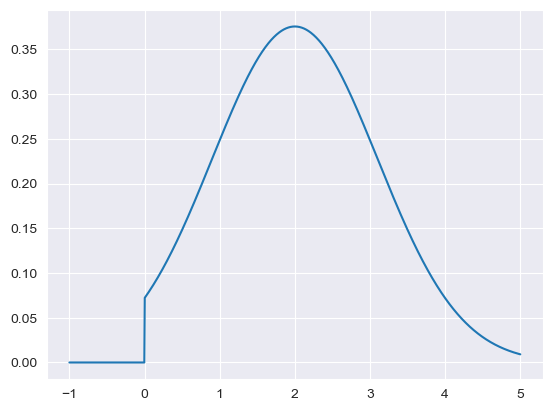

In [7]:
minimum = limit_a = 0
maximum = limit_b = np.inf
value = mean = 2
cv = 0.55
sd = cv*mean

a, b = (limit_a - mean) / sd, (limit_b - mean) / sd
x_range = np.linspace(-1,5,1000)
plt.plot(x_range, stats.truncnorm.pdf(x_range, a, b, loc = mean, scale = sd))

## Uniform distribution

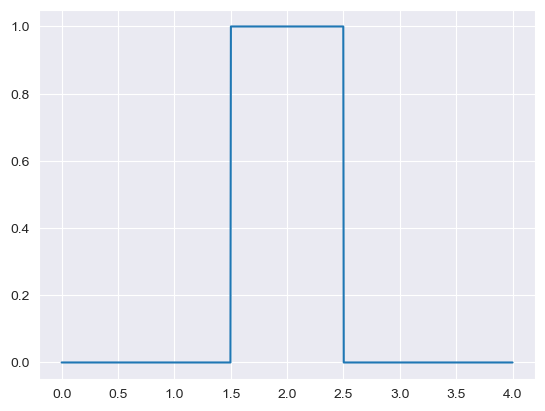

In [8]:
value = mean = 2
cv = 0.25
sd = mean*cv
a = mean-sd
b = mean+sd

if a < 0:
    a = 0
x_range = np.linspace(0,4,1000)
plt.plot(x_range, stats.uniform.pdf(x_range, loc = a, scale = b - a))

## Uniform Recycling


Recycling rates uniform uncertainty is estimated downwards by moving the uniform window to 1.5 times the standard deviation toward the lower bound and only 0.5 times toward the upper bound. This is based on the assumption that recycling rates are somewhat unlikely to be higher than reported.

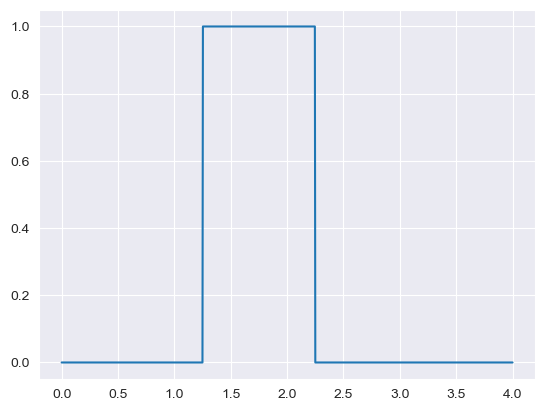

In [9]:
value = mean = 2
cv = 0.25
sd = mean*cv
a = mean-1.5*sd
b = mean+0.5*sd

if a < 0:
    a = 0
x_range = np.linspace(0,4,1000)
plt.plot(x_range, stats.uniform.pdf(x_range, loc = a, scale = b - a))

## Lognormal distribution

Variables that are defined by a mean ($\mu_{X})$ and a CV ($CV= \frac{\sigma_{X}}{\mu_{X}}$) are represented in the LogNormal distribution by the
$\mu =\ln \left({\frac {\mu _{X}^{2}}{\sqrt {\mu _{X}^{2}+\sigma _{X}^{2}}}}\right), \quad \sigma ^{2}=\ln \left(1+{\frac {\sigma _{X}^{2}}{\mu _{X}^{2}}}\right)$ (see: https://en.wikipedia.org/wiki/Log-normal_distribution)

Mean and standard deviation of the original Normal distribution are retained, but the LogNormal distribution will be slightly skewed to the right.

In [10]:
mu_x = 50
cv = 0.3
var_x = (mu_x*0.3)

mu_lognormal = np.log(
    mu_x**2/np.sqrt(mu_x**2+var_x**2)
)
var_lognormal = np.log(1+(var_x**2/mu_x**2))
frozen_lognorm = stats.lognorm(s=np.sqrt(var_lognormal),loc=0, scale=np.exp(mu_lognormal))


50.062108471274215

15.016345817598006

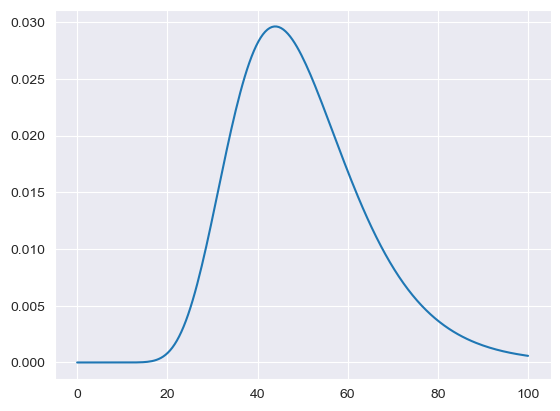

In [11]:
x=np.linspace(0,100,200)
plt.plot(x, frozen_lognorm.pdf(x))
test_values = frozen_lognorm.rvs(100000)
display(np.mean(test_values))
display(np.std(test_values))

## LogNormal of Lifetimes

LogNormal for lifetimes is processed via the ODYM module and follows a different format.
The parameter MISO2_Lifetimes is interpreted as mean values, while the parameter MISO2_Lifetimes_deviation is the corresponding standard deviation.

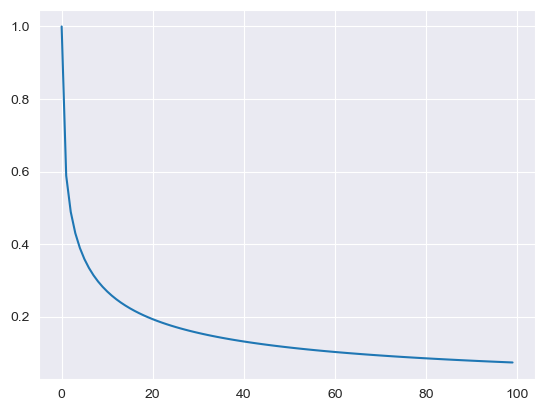

In [12]:
lt = {"Mean": 80, "StdDev": 1.85}

LT_LN = np.log(lt['Mean'] / np.sqrt(1 + lt['Mean'] * lt['Mean'] / (
        lt['StdDev'] * lt['StdDev'])))
# calculate parameter sigma of underlying normal distribution:
SG_LN = np.sqrt(np.log(1 + lt['Mean'] * lt['Mean'] / (
        lt['StdDev'] * lt['StdDev'])))
# compute survial function
sf = stats.lognorm.sf(np.arange(0, 100), s=SG_LN, loc=0,
                                         scale=np.exp(LT_LN))
plt.plot(sf)
# plt.savefig("sf_stdlogn.png")

## Dirichlet distribution

Unlike the other distributions, the Dirichlet distribution requires a vector of input measures. In the context of the MISO2 software, these are most likely enduse shares, which are required to sum up to 1. CV is taken to be the concentration parameter alpha, which determines the shape of the Dirichlet distribution, e.g. at which end values are concentrated. The higher alpha, the closer the random values will be to the original values, while lower alpha will skew the distribution towards one of the ends depending on their prior values.

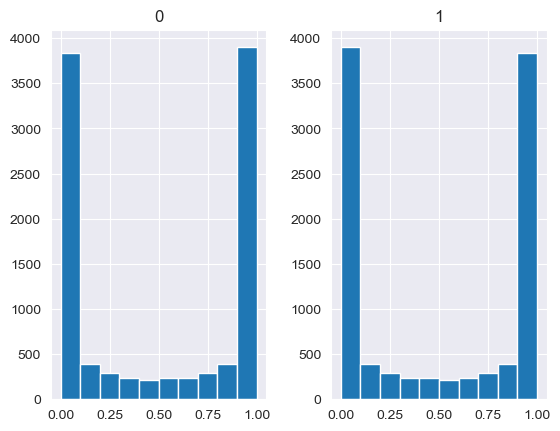

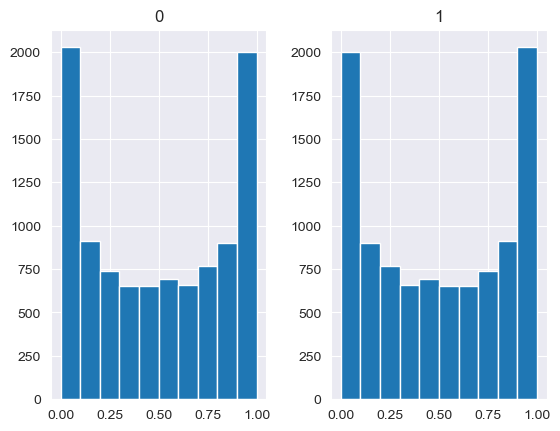

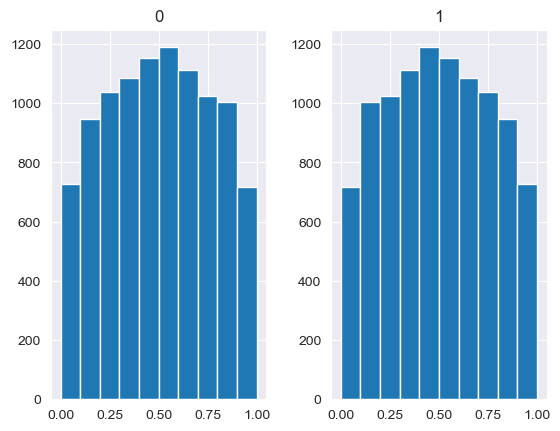

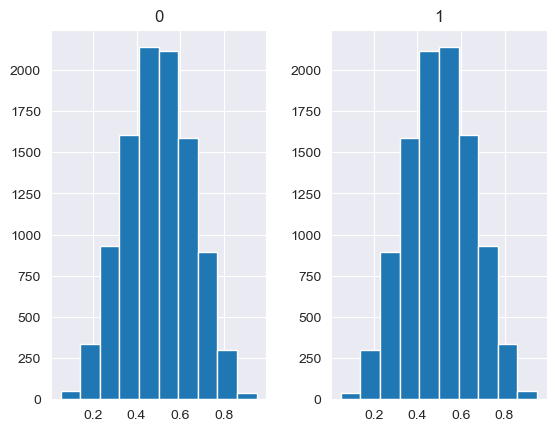

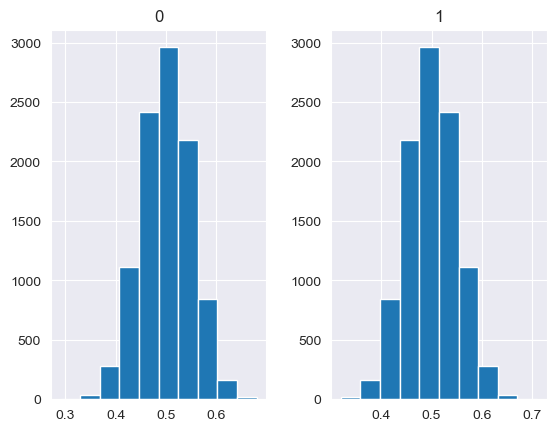

In [88]:
values = base_measures = np.array([0.5,0.5])
cv = alphas = [0.25,1,2.5,10,100]
# concentration parameter if equal for all values, could also be different for each base measure
for alpha in alphas:
    n_samples = 10000
    samples = {}
    dirichlet_samples = stats.dirichlet(base_measures*alpha).rvs(10000)
    pd.DataFrame(dirichlet_samples).hist()

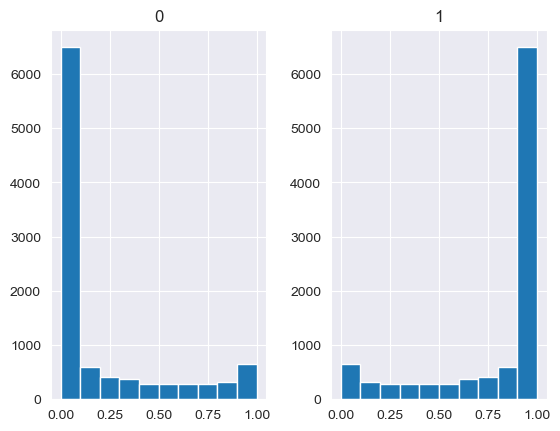

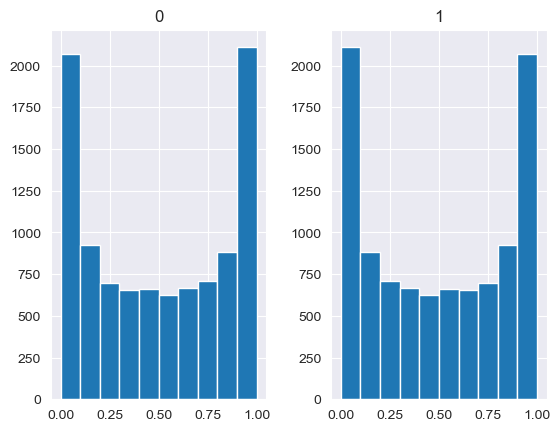

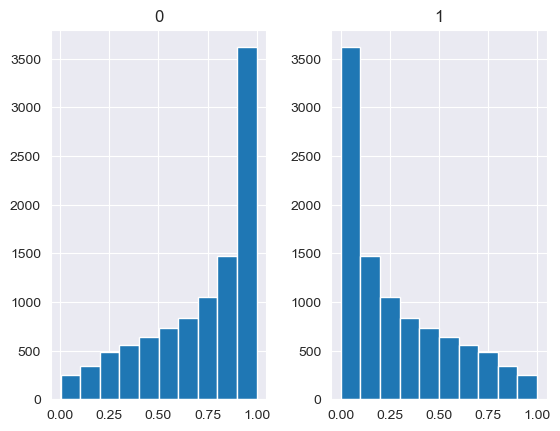

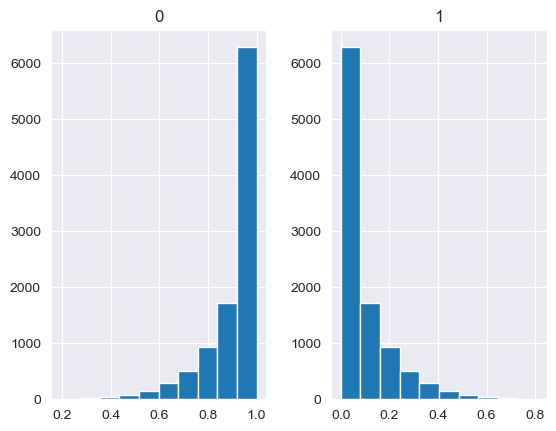

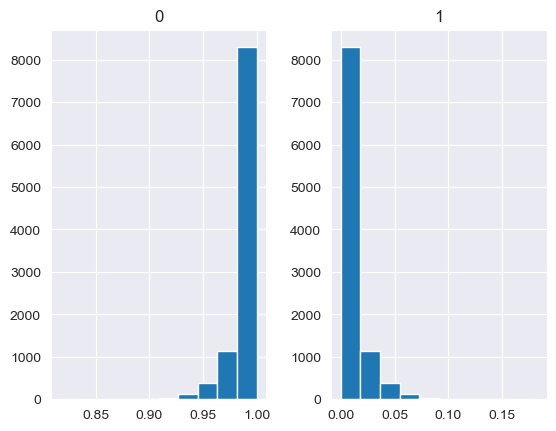

In [89]:
base_measures = np.array([0.5,0.5])
alphas = np.array([[0.25,1],[1,1],[2.5,1],[10,1],[100,1]])
# concentration parameter if equal for all values, could also be different for each base measure
for alpha in alphas:
    n_samples = 10000
    samples = {}
    dirichlet_samples = stats.dirichlet(base_measures*alpha).rvs(10000)
    pd.DataFrame(dirichlet_samples).hist()